# KMEANS Algorithm with OPENSMILE Library

In [ ]:
pip install librosa soundfile transformers pytorch HDBScan umap matplotlib umap-learn sentence-transformers

In [20]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import umap
import hdbscan
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import opensmile
from sentence_transformers import SentenceTransformer

# Set the random seed for reproducibility
np.random.seed(42)

In [3]:
# Define the directory where the RAVDESS audio files are stored.
# Adjust this path to the location of your dataset.
audio_dir = "data/"

# Get a list of all audio file paths
audio_files = []
for root, dirs, files in os.walk(audio_dir):
    for file in files:
        if file.endswith(".wav"):
            audio_files.append(os.path.join(root, file))

print(f"Found {len(audio_files)} audio files.")

Found 8882 audio files.


# Our New Approach of an SLM-Based Lexical-Paralinguistics Hybrid Approach  

## Transcription of audio 

In [10]:
import torch
import librosa
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

# Load the pretrained Wav2Vec2 model and processor
model_name = "facebook/wav2vec2-base-960h"
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2ForCTC.from_pretrained(model_name)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
def transcribe_audio(file_path):
    """
    Transcribe an audio file using the Wav2Vec2 model.
    Assumes audio is in English and resampled to 16000 Hz.
    """
    # Load audio file; librosa loads as float32 and downmixes to mono automatically
    audio, sr = librosa.load(file_path, sr=16000)
    
    # Process audio to get input values for the model
    input_values = processor(audio, return_tensors="pt", sampling_rate=16000).input_values
    
    # Get logits from the model
    with torch.no_grad():
        logits = model(input_values).logits

    # Decode the logits to get transcription; use argmax decoding here (can be replaced with beam search if needed)
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)[0]
    
    return transcription

In [12]:
# Example: transcribe a single file
transcript = transcribe_audio(audio_files[0])
print("Transcript:", transcript)

Transcript: KIDS ARE TALKING BY THE DOOR


In [13]:
transcripts = []
for file in audio_files:    
    try:
        t = transcribe_audio(file)
        transcripts.append(t)
    except Exception as e:
        print(f"Error transcribing {file}: {e}")
        transcripts.append("")  # Append an empty string if there is an error

# Now you have a 'transcripts' list in the same order as your audio_files and feature extraction.

### Exraction of Paralinguistic cues using OPENSMILE Library

In [18]:
# Initialize the OpenSMILE feature extractor with the eGeMAPS configuration
# Note: 'eGeMAPSv01a' is one of the available configurations.
smile = opensmile.Smile(
    feature_set='eGeMAPSv01a',   # Choose a feature set; other options include 'IS09_emotion', 'ComParE_2016', etc.
    feature_level='Functionals'  # Functionals summarise statistics (like mean, std, etc.) over the entire audio file
)

# Function to extract features using OpenSMILE for a given audio file.
def extract_paralinguistic_features(file_path):
    try:
        # Process the file using OpenSMILE; this returns a pandas DataFrame
        features_df = smile.process_file(file_path)
        # Convert the DataFrame to a numpy array (we drop the 'name' column if present)
        features_array = features_df.values.squeeze()  # Ensure a 1D array per file
        return features_array
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

paralinguistic_features_list = []
file_names = []  # track file names


for file in audio_files:
    feat = extract_paralinguistic_features(file)
    if feat is not None:
        paralinguistic_features_list.append(feat)
        file_names.append(file)
        
paralinguistic_features = np.array(paralinguistic_features_list)
print("Paralinguistic features shape:", paralinguistic_features.shape) 

Paralinguistic features shape: (8882, 88)


In [21]:
# Initialize the SentenceTransformer (a small model suitable for our case)
slm_model = SentenceTransformer("all-MiniLM-L6-v2")  # a compact SLM

# Obtain embeddings for the transcripts (lexical features)
lexical_features = slm_model.encode(transcripts)
print("Lexical features shape:", lexical_features.shape)

Lexical features shape: (8882, 384)


In [22]:
# ------------- Feature Fusion -------------
# For a simple fusion, we concatenate the paralinguistic and lexical features.
# You may want to experiment with weighting and dimensionality reduction before fusion.
fused_features = np.concatenate([paralinguistic_features, lexical_features], axis=1)
print("Fused features shape:", fused_features.shape)

Fused features shape: (8882, 472)


C:\Users\jianhong\anaconda3\envs\HuggingFace\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jianhong\anaconda3\envs\HuggingFace\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Reduced fused features shape: (8882, 2)


C:\Users\jianhong\AppData\Local\Temp\ipykernel_19484\752384190.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(features_umap[:, 0], features_umap[:, 1], s=5, cmap="Spectral")


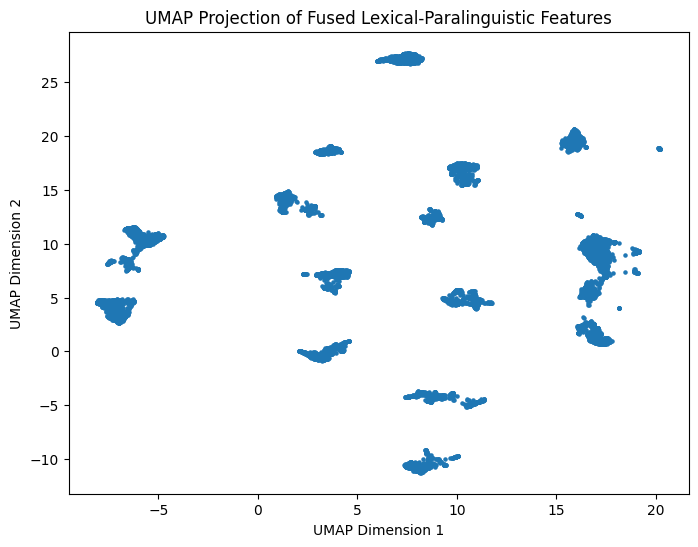

In [23]:
# ------------- Standardize and Reduce Dimensionality -------------
scaler = StandardScaler()
features_scaled = scaler.fit_transform(fused_features)

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
features_umap = reducer.fit_transform(features_scaled)
print("Reduced fused features shape:", features_umap.shape)

plt.figure(figsize=(8, 6))
plt.scatter(features_umap[:, 0], features_umap[:, 1], s=5, cmap="Spectral")
plt.title("UMAP Projection of Fused Lexical-Paralinguistic Features")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show() 

### KMEANS Clustering 

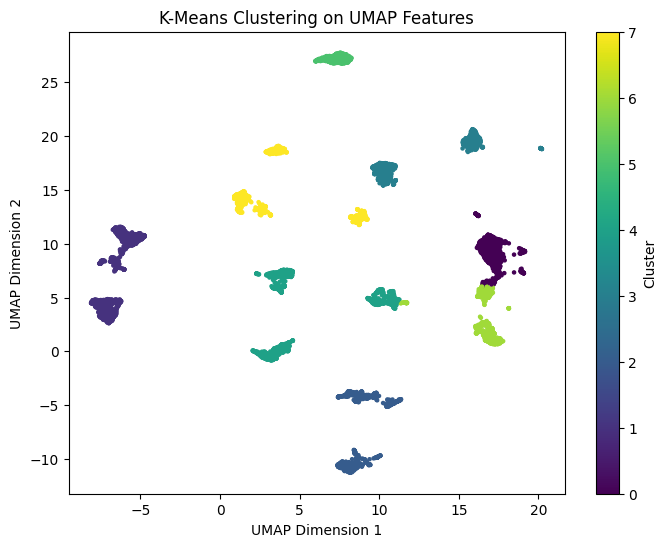

Silhouette Score (opensmile + KMeans): 0.59267473
Davies-Bouldin Index (opensmile + KMeans): 0.5946751875304629
alinski-Harabasz Index (opensmile + KMeans): 16527.426


In [24]:
# Set number of clusters (e.g., RAVDESS has 8 emotions, but unsupervised learning might reveal different structures)
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(features_umap)

# Visualize K-Means clusters
plt.figure(figsize=(8, 6))
plt.scatter(features_umap[:, 0], features_umap[:, 1], c=kmeans_labels, cmap="viridis", s=5)
plt.title("K-Means Clustering on UMAP Features")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(label="Cluster")
plt.show()

opensmile_kmeans_score = silhouette_score(features_umap, kmeans_labels)
opensmile_kmeans_db = davies_bouldin_score(features_umap, kmeans_labels)
opensmile_kmeans_ch = calinski_harabasz_score(features_umap, kmeans_labels)

print("Silhouette Score (opensmile + KMeans):", opensmile_kmeans_score)
print("Davies-Bouldin Index (opensmile + KMeans):", opensmile_kmeans_db)
print("alinski-Harabasz Index (opensmile + KMeans):", opensmile_kmeans_ch)

Lets Look at how we might be able to push this further. 

Ways to improve :  
- CLS Token Embedding ?
- Weighted Pooling
- Sentence-Level Embedding
- Improve Fusion of features, smarter fusion might help. Can try PCA or autoencoder

# Improvement Part 1 : Comparison of other models for Lexical Features  
- Bert ( Bidrectional Encoder Representations from transformers )
- DistilBERT (Distilled BERT):
- RoBERTa (A Robustly Optimized BERT Pretraining Approach):

In [25]:
from transformers import BertTokenizer, BertModel
from transformers import DistilBertTokenizer, DistilBertModel
from transformers import RobertaTokenizer, RobertaModel

# BERT model and tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

def get_bert_embeddings(text):
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = bert_model(**inputs)
    # Extract [CLS] token embedding and reshape to (1, embedding_dim)
    return outputs.last_hidden_state[:, 0, :].detach().numpy()

# DistilBERT model and tokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
distilbert_model = DistilBertModel.from_pretrained("distilbert-base-uncased")

def get_distilbert_embeddings(text):
    inputs = distilbert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = distilbert_model(**inputs)
    # Extract [CLS] token embedding
    return outputs.last_hidden_state[:, 0, :].detach().numpy()

# RoBERTa model and tokenizer
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = RobertaModel.from_pretrained("roberta-base")

def get_roberta_embeddings(text):
    inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = roberta_model(**inputs)
    # Extract [CLS] token embedding
    return outputs.last_hidden_state[:, 0, :].detach().numpy()

# Get embeddings for all transcripts
bert_features = np.array([get_bert_embeddings(transcript) for transcript in transcripts])
distilbert_features = np.array([get_distilbert_embeddings(transcript) for transcript in transcripts])
roberta_features = np.array([get_roberta_embeddings(transcript) for transcript in transcripts])

# Now, these are 2D arrays (samples, features) and can be scaled
print("BERT Lexical Features Shape:", bert_features.shape)
print("DistilBERT Lexical Features Shape:", distilbert_features.shape)
print("RoBERTa Lexical Features Shape:", roberta_features.shape)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT Lexical Features Shape: (8882, 1, 768)
DistilBERT Lexical Features Shape: (8882, 1, 768)
RoBERTa Lexical Features Shape: (8882, 1, 768)


In [26]:
# Performing K-Means Algorithm 

C:\Users\jianhong\anaconda3\envs\HuggingFace\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jianhong\anaconda3\envs\HuggingFace\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\jianhong\anaconda3\envs\HuggingFace\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jianhong\anaconda3\envs\HuggingFace\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


        Model  Silhouette Score  Davies-Bouldin Index  Calinski-Harabasz Index
0        BERT          0.587290              0.633921             11276.040039
1  DistilBERT          0.611604              0.624821             12959.646484
2     RoBERTa          0.593878              0.620112             13825.484375


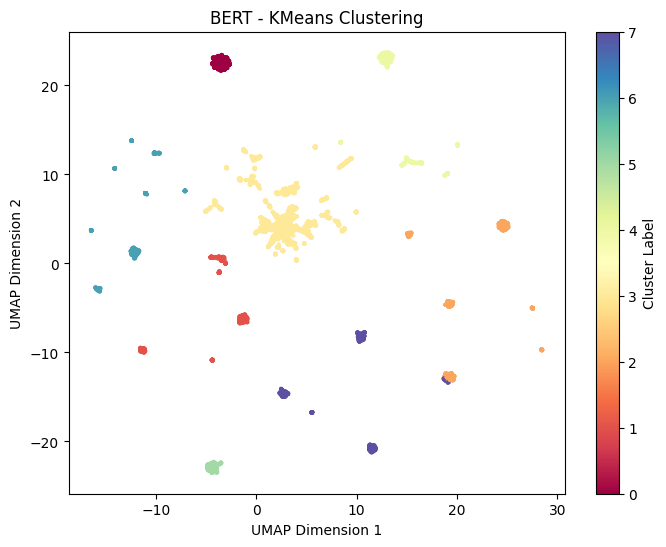

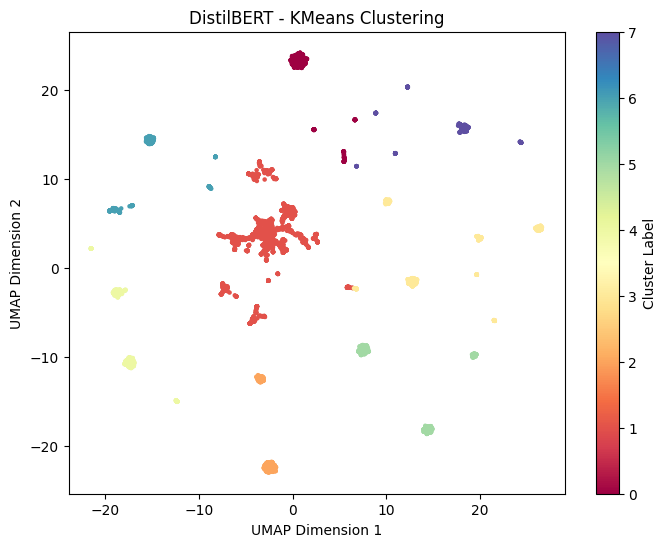

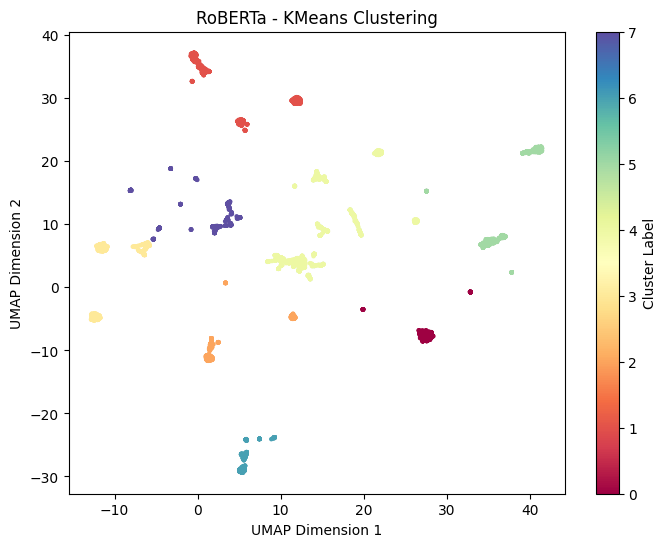

In [28]:
import pandas as pd
import numpy as np
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

# Assuming the features from all models (BERT, DistilBERT, RoBERTa) are available as numpy arrays
# Let's assume the variables: bert_features, distilbert_features, roberta_features are available

# Reshape the embeddings to 2D: (samples, embedding_dim) by squeezing the sequence dimension
bert_features_reshaped = bert_features.squeeze(axis=1)  # Remove the sequence dimension
distilbert_features_reshaped = distilbert_features.squeeze(axis=1)
roberta_features_reshaped = roberta_features.squeeze(axis=1)

# Now, scale the reshaped features
scaler = StandardScaler()

bert_scaled = scaler.fit_transform(bert_features_reshaped)
distilbert_scaled = scaler.fit_transform(distilbert_features_reshaped)
roberta_scaled = scaler.fit_transform(roberta_features_reshaped)

# Step 2: Dimensionality reduction with UMAP
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)

# Reduce dimensionality of each model's features
bert_umap = umap_reducer.fit_transform(bert_scaled)
distilbert_umap = umap_reducer.fit_transform(distilbert_scaled)
roberta_umap = umap_reducer.fit_transform(roberta_scaled)

# Step 3: Perform KMeans clustering on the reduced features
n_clusters = 8  # Adjust the number of clusters based on your data

# Perform K-Means clustering for each model
kmeans_bert = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_distilbert = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_roberta = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the models
bert_labels = kmeans_bert.fit_predict(bert_umap)
distilbert_labels = kmeans_distilbert.fit_predict(distilbert_umap)
roberta_labels = kmeans_roberta.fit_predict(roberta_umap)

# Step 4: Calculate clustering metrics for each model's clustering
def calculate_clustering_metrics(features, labels):
    # Calculate the Silhouette Score
    silhouette = silhouette_score(features, labels)
    
    # Calculate the Davies-Bouldin Index
    davies_bouldin = davies_bouldin_score(features, labels)
    
    # Calculate the Calinski-Harabasz Index
    calinski_harabasz = calinski_harabasz_score(features, labels)
    
    return silhouette, davies_bouldin, calinski_harabasz

# Calculate metrics for each model
bert_silhouette, bert_davies_bouldin, bert_calinski_harabasz = calculate_clustering_metrics(bert_umap, bert_labels)
distilbert_silhouette, distilbert_davies_bouldin, distilbert_calinski_harabasz = calculate_clustering_metrics(distilbert_umap, distilbert_labels)
roberta_silhouette, roberta_davies_bouldin, roberta_calinski_harabasz = calculate_clustering_metrics(roberta_umap, roberta_labels)

# Step 5: Create a pandas DataFrame to print the metrics in a table format
metrics_data = {
    'Model': ['BERT', 'DistilBERT', 'RoBERTa'],
    'Silhouette Score': [bert_silhouette, distilbert_silhouette, roberta_silhouette],
    'Davies-Bouldin Index': [bert_davies_bouldin, distilbert_davies_bouldin, roberta_davies_bouldin],
    'Calinski-Harabasz Index': [bert_calinski_harabasz, distilbert_calinski_harabasz, roberta_calinski_harabasz]
}

metrics_df = pd.DataFrame(metrics_data)

# Print the table
print(metrics_df)

# Step 6: Visualize the clustering for each model (Optional)

def plot_umap_with_clusters(features, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(features[:, 0], features[:, 1], c=labels, cmap="Spectral", s=5)
    plt.title(f"{title} - KMeans Clustering")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.colorbar(label="Cluster Label")
    plt.show()

# Plot UMAP projections and K-Means clusters
plot_umap_with_clusters(bert_umap, bert_labels, "BERT")
plot_umap_with_clusters(distilbert_umap, distilbert_labels, "DistilBERT")
plot_umap_with_clusters(roberta_umap, roberta_labels, "RoBERTa")

In [30]:
# Results K Means Clustering on OpenSmile 
# Model  Silhouette Score  Davies-Bouldin Index  Calinski-Harabasz Index
# 0        BERT          0.587290              0.633921             11276.040039
# 1  DistilBERT          0.611604              0.624821             12959.646484
# 2     RoBERTa          0.593878              0.620112             13825.484375 

DistilBERT seems to be performing the best, the clustering make sense as well, we can use this for the other models moving forward. 

# Analysing our model ( DistilBERT & OpenSMILE ) 

In [31]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def get_representative_transcripts(embeddings, labels, transcripts, top_k=3):
    cluster_texts = {}
    for cluster_id in np.unique(labels):
        indices = np.where(labels == cluster_id)[0]
        cluster_embs = embeddings[indices]
        centroid = np.mean(cluster_embs, axis=0, keepdims=True)

        sims = cosine_similarity(cluster_embs, centroid).flatten()
        top_indices = indices[np.argsort(sims)[-top_k:]]
        cluster_texts[cluster_id] = [transcripts[i] for i in top_indices]
    return cluster_texts

In [47]:
# Use this with DistilBERT embeddings
representatives = get_representative_transcripts(distilbert_features_reshaped, distilbert_labels, transcripts, top_k=3)

for cluster, reps in representatives.items():
    print(f"\nCluster {cluster}:")
    for i, t in enumerate(reps):
        print(f"  Example {i+1}: {t}")


Cluster 0:
  Example 1: IT'S ELEVEN O'CLOCK
  Example 2: IT'S ELEVEN O'CLOCK
  Example 3: IT'S ELEVEN O'CLOCK

Cluster 1:
  Example 1: I WANT TOSABOUT
  Example 2: I THINK I HAVE A DACTOR'S APARTME
  Example 3: I THINK I'VE SEEN THIS BEFOER

Cluster 2:
  Example 1: DOGS ARE SITTING BY THE DOOR
  Example 2: DOGS ARE SITTING BY THE DOOR
  Example 3: AND DOGS ARE SITTING BY THE DOOR

Cluster 3:
  Example 1: I WONDER WHAT THIS IS ABOUT
  Example 2: I WONDER WHAT THIS IS ABOUT
  Example 3: I WONDER WHAT THIS IS

Cluster 4:
  Example 1: KIDS ARE TALKING BY THE DOOR
  Example 2: KIDS ARE TALKING BY THE DOOR
  Example 3: KIDS ARE DOGGING BY THE DOOR

Cluster 5:
  Example 1: THAT IS EXACTLY WHAT HAPPENED
  Example 2: THAT IS EXACTLY WHAT HAPPENED
  Example 3: THAT IS EXACTLY WHAT HAPPENED

Cluster 6:
  Example 1: DON'T FORGET A JACKET
  Example 2: DON'T FORGET A JACKET
  Example 3: DON'T FORGET A JACKET

Cluster 7:
  Example 1: I THINK I HAVE A DOCTOR'S APPOINTMENT
  Example 2: I THINK I HAVE 

In [37]:
paralinguistic_features = np.array(paralinguistic_features_list)

In [39]:
# Convert to DataFrame for easier handling
para_df = pd.DataFrame(paralinguistic_features, columns=[f"feat_{i}" for i in range(paralinguistic_features.shape[1])])
para_df["cluster"] = kmeans_labels  # Assign cluster labels from fused model

# Compute the mean feature vector per cluster
cluster_profiles = para_df.groupby("cluster").mean()

print(cluster_profiles.head())  # First few rows

            feat_0    feat_1     feat_2     feat_3     feat_4    feat_5  \
cluster                                                                   
0        32.056789  0.079926  30.308664  32.329399  33.958672  3.650009   
1        34.156948  0.121158  31.493690  34.253414  37.168217  5.674525   
2        31.883181  0.096303  29.778881  31.797693  34.216110  4.437226   
3        32.258999  0.105132  29.454798  32.574249  35.043789  5.588992   
4        31.600370  0.094469  29.419828  31.645306  33.974365  4.554535   

             feat_6      feat_7     feat_8     feat_9  ...   feat_78  \
cluster                                                ...             
0         60.886192   34.117424  29.200365  23.488823  ... -0.007843   
1        139.544388  130.579346  57.662884  56.507103  ...  0.044697   
2         78.631378   59.626877  44.782928  45.225239  ... -0.002539   
3         78.128052   51.139618  40.948639  24.708805  ... -0.005291   
4         66.126053   44.564438  39.565762

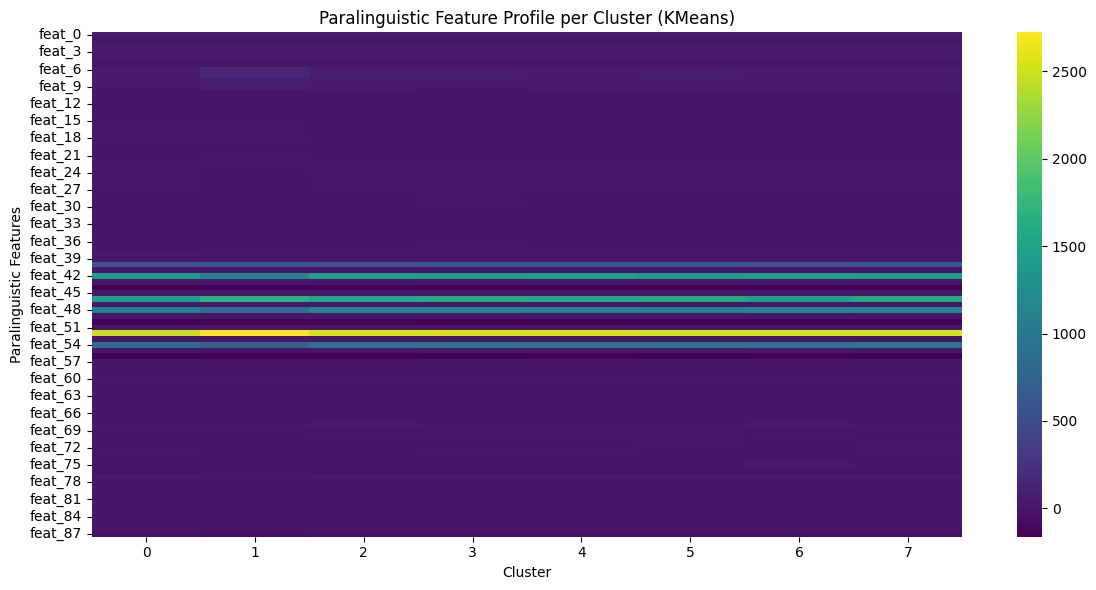

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profiles.T, cmap="viridis", annot=False)
plt.title("Paralinguistic Feature Profile per Cluster (KMeans)")
plt.xlabel("Cluster")
plt.ylabel("Paralinguistic Features")
plt.tight_layout()
plt.show()

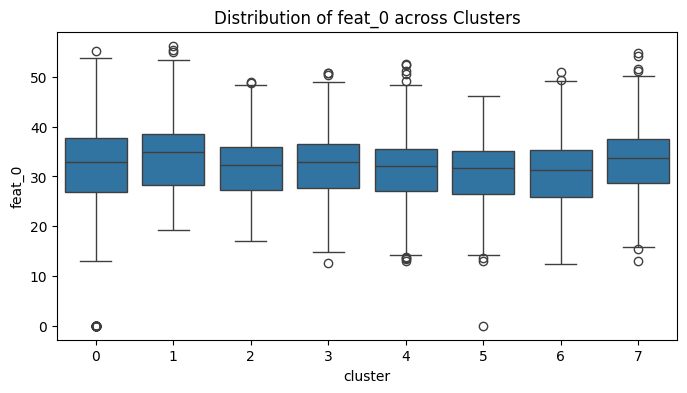

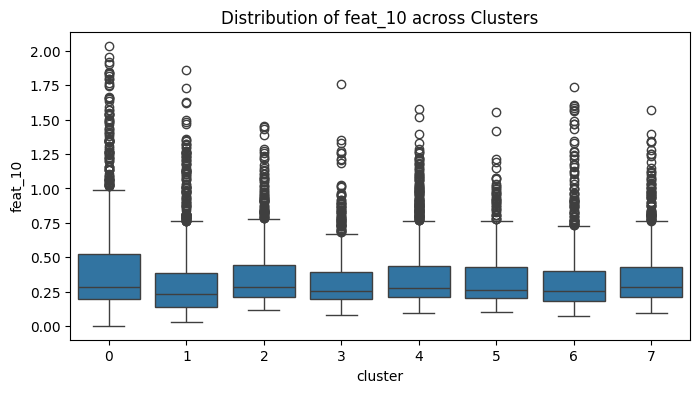

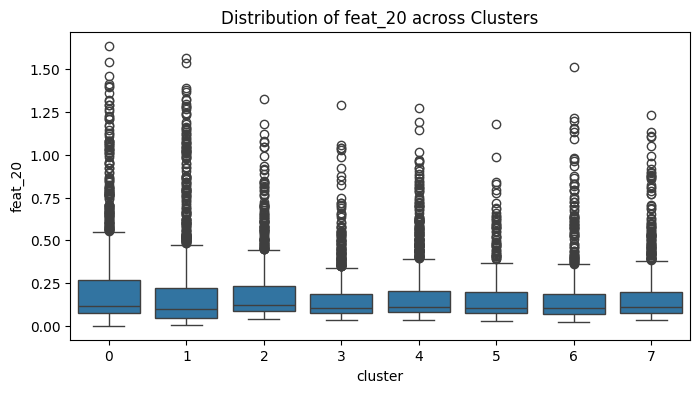

In [41]:
selected_features = ['feat_0', 'feat_10', 'feat_20']  # Just examples — customize

for feat in selected_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='cluster', y=feat, data=para_df)
    plt.title(f"Distribution of {feat} across Clusters")
    plt.show()


Play Audio and describe it with emotion like words 

In [46]:
import numpy as np
from IPython.display import Audio

# Compute Euclidean distance between each sample and the cluster centroid
centroids = np.array([paralinguistic_features[kmeans_labels == i].mean(axis=0) for i in range(7)])
distances = np.linalg.norm(paralinguistic_features[:, None] - centroids, axis=2)

# For each cluster, find the indices of the top 5 closest samples
top_5_samples_per_cluster = []
for i in range(7):
    # Get the indices of the top 5 closest samples to the centroid for each cluster
    closest_indices = np.argsort(distances[:, i])[:5]  # Sort by distance and get top 5
    top_5_samples_per_cluster.append(closest_indices)

# Assuming you have a list of file paths for the audio samples
file_paths = [audio_files[i] for i in np.concatenate(top_5_samples_per_cluster)]

# Play the top 5 audio samples from each cluster
for file_path in file_paths:
    display(Audio(file_path))

# Building some ground truth into the model as further valuataion 

In [1]:
import os
import pandas as pd

# Define base paths
base_path = 'data'
ravdess_base = base_path
crema_base = os.path.join(base_path, 'archive', 'AudioWAV')

# Emotion mapping
EMOTION_MAP = {
    'ANG': 'angry',
    'DIS': 'disgust',
    'FEA': 'fear',
    'HAP': 'happy',
    'NEU': 'neutral',
    'SAD': 'sad',
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fear',
    '07': 'disgust',
    '08': 'surprise'
}

# List to hold parsed entries
ground_truth = []

# === Parse CREMA-D ===
for fname in os.listdir(crema_base):
    if fname.endswith('.wav'):
        parts = fname.split('_')
        speaker_id = parts[0]
        raw_emotion = parts[2]
        ground_truth.append({
            'file_name': fname,
            'dataset': 'CREMA-D',
            'speaker_id': speaker_id,
            'emotion_label': EMOTION_MAP[raw_emotion]
        })

# === Parse RAVDESS ===
for folder in os.listdir(ravdess_base):
    if folder.startswith('Actor'):
        actor_path = os.path.join(ravdess_base, folder)
        for fname in os.listdir(actor_path):
            if fname.endswith('.wav'):
                parts = fname.split('.')[0].split('-')
                emotion_code = parts[2]
                speaker_id = parts[-1]
                ground_truth.append({
                    'file_name': fname,
                    'dataset': 'RAVDESS',
                    'speaker_id': speaker_id,
                    'emotion_label': EMOTION_MAP[emotion_code]
                })

# === Convert to DataFrame and Save ===
ground_truth_df = pd.DataFrame(ground_truth)
ground_truth_df.to_csv('ground_truth_labels.csv', index=False)

print(f"Ground truth file saved with {len(ground_truth_df)} entries.")

✅ Ground truth file saved with 8882 entries.


In [2]:
ground_truth_df

file_name  dataset speaker_id emotion_label
0          1001_DFA_ANG_XX.wav  CREMA-D       1001         angry
1          1001_DFA_DIS_XX.wav  CREMA-D       1001       disgust
2          1001_DFA_FEA_XX.wav  CREMA-D       1001          fear
3          1001_DFA_HAP_XX.wav  CREMA-D       1001         happy
4          1001_DFA_NEU_XX.wav  CREMA-D       1001       neutral
...                        ...      ...        ...           ...
8877  03-01-08-01-02-02-24.wav  RAVDESS         24      surprise
8878  03-01-08-02-01-01-24.wav  RAVDESS         24      surprise
8879  03-01-08-02-01-02-24.wav  RAVDESS         24      surprise
8880  03-01-08-02-02-01-24.wav  RAVDESS         24      surprise
8881  03-01-08-02-02-02-24.wav  RAVDESS         24      surprise

[8882 rows x 4 columns]

C:\Users\jianhong\anaconda3\envs\HuggingFace\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jianhong\anaconda3\envs\HuggingFace\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


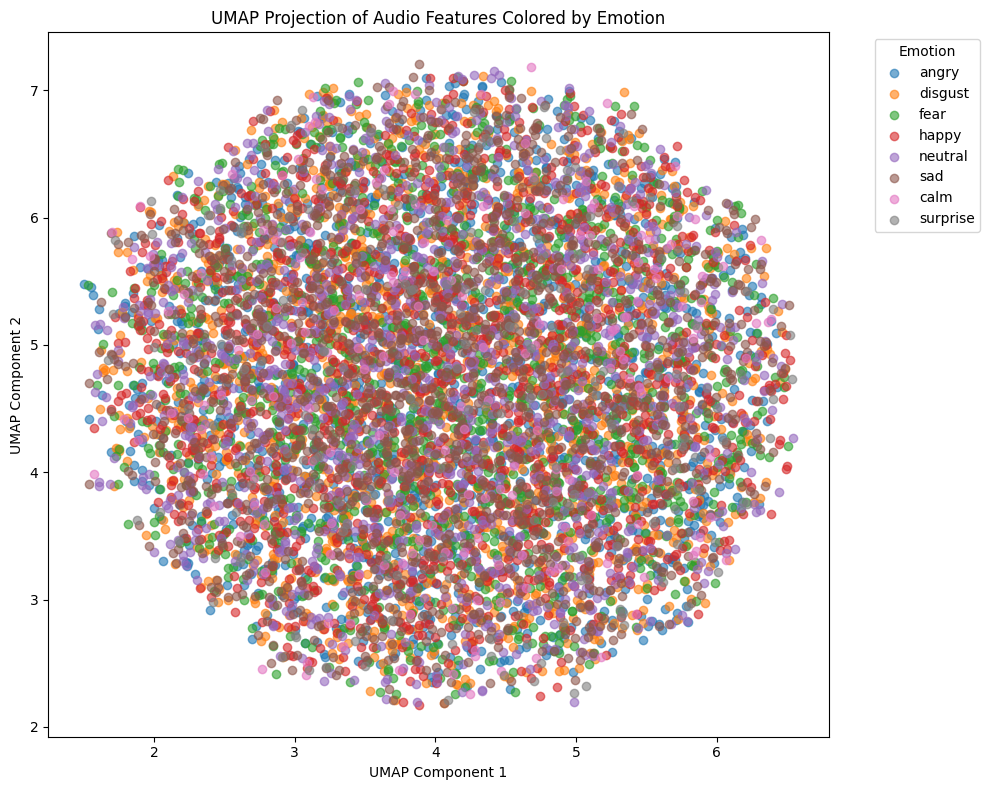

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import umap

np.random.seed(42)  # For reproducibility
features = np.random.rand(len(ground_truth_df), 256)  # Simulated 256-dimensional features

# Perform UMAP dimensionality reduction
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_model.fit_transform(features)

# Add UMAP components to the DataFrame
ground_truth_df['umap_x'] = umap_embeddings[:, 0]
ground_truth_df['umap_y'] = umap_embeddings[:, 1]

# Create a scatter plot colored by the emotion label
plt.figure(figsize=(10, 8))
for emotion in ground_truth_df['emotion_label'].unique():
    emotion_data = ground_truth_df[ground_truth_df['emotion_label'] == emotion]
    plt.scatter(emotion_data['umap_x'], emotion_data['umap_y'], label=emotion, alpha=0.6)

plt.title('UMAP Projection of Audio Features Colored by Emotion')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()